ROI Pooling Demo

The ROI pooling layer is a specialized version of the max pooling layer commonly used in convolutional neural networks. A max pooling layer is typically used to spatially downsample a 2d feature map by choosing the maximum value from a small region corresponding to a particular output pixel. The ROI pooling layer does the same thing, but also takes as input a set of ROIs (regions of interest) over which to pool. This is essentially equivalent to max pooling the input image croppped to each ROI, and computing the stride of the pooling such that each output feature map has the same size no matter the ROI size. 

The ROI pooling layer is used in algorithms such as Fast-RCNN, which use it to pool over the output of the last convolutional layer of a CNN for a number of input ROIs. This allows the inspection of various regions of an image, but without having to run all the convoulational layers on each individual crop of the image. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import ops

import os
home = os.getenv("HOME")

In [2]:
# Since we've added custom operations, we need to import them. Tensorflow does not automatically add custom ops.
# Adjust the paths below to your tensorflow source folder.

# Import the forward op
roi_pooling_module = tf.load_op_library(
    home + "/packages/tensorflow/bazel-bin/tensorflow/core/user_ops/roi_pooling_op.so")
roi_pooling_op = roi_pooling_module.roi_pooling

# Import the gradient op
roi_pooling_module_grad = tf.load_op_library(
    home + "/packages/tensorflow/bazel-bin/tensorflow/core/user_ops/roi_pooling_op_grad.so")
roi_pooling_op_grad = roi_pooling_module_grad.roi_pooling_grad

In [3]:
# Open a demo image
im = Image.open("cat.png").convert("L")

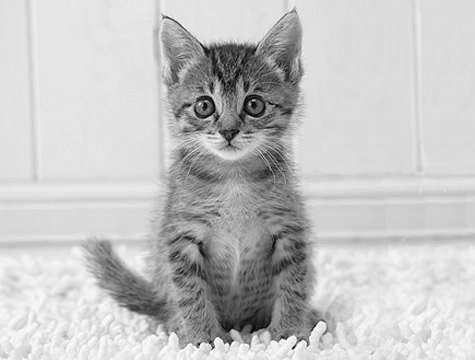

In [4]:
# Show the image
im

In [5]:
# Image dimensions - HW ordering
np.asarray(im).shape

(360, 475)

In [6]:
# Prepare demo inputs
num_batches = 1

# Test ROIs
rois = [(0, 0, 300, 400), (150, 150, 50, 200)]
# Data ordering: num batches, num ROIs, (x, y, height, width)
roi_array = np.asarray(rois).astype(int).reshape(len(rois), 4)
roi_array = np.asarray([roi_array for i in range(num_batches)])

# Input image
# Crop dimensions (for easy testing of various input sizes)
image_width = 403
image_height = 304
input_image = Image.open("cat.png").convert("L").crop((0, 0, image_width, image_height))
# Should be in NCHW format (num batches, num channels, height, width)
input_array = np.asarray(input_image).reshape(1, image_height, image_width)
input_array = np.asarray([input_array for i in range(num_batches)])

# Output should be a tensor of this shape
# height, width
output_shape = np.asarray((50, 80)).astype(np.int32)

# Prepare an array of random numbers to test gradient backpropagation
# Should be same size as output of ROI pooling layer
grad_test = np.random.random((1, 1, len(roi_array), output_shape[0], output_shape[1]))

In [7]:
# Here we register our gradient op as the gradient function for our ROI pooling op. 
@ops.RegisterGradient("RoiPooling")
def _roi_pooling_grad(op, grad0, grad1):
    # The input gradients are the gradients with respect to the outputs of the pooling layer
    input_grad = grad0
    
    # We need the argmax data to compute the gradient connections
    argmax = op.outputs[1]
    
    # Grab the shape of the inputs to the ROI pooling layer
    input_shape = array_ops.shape(op.inputs[0])
    
    # Compute the gradient
    backprop_grad = roi_pooling_op_grad(input_grad, argmax, input_shape)
    
    # Return the gradient for the feature map, but not for the other inputs
    return [backprop_grad, None, None]

In [8]:
# Set up the TensorFlow operations to test

# Placeholders are placeholders for the input data. Passed in for each computation.
data = tf.placeholder(tf.float32)
rois = tf.placeholder(tf.int32)
grad = tf.placeholder(tf.float32)
output_shape_tensor = tf.placeholder(tf.int32)

# Get the shape of the input feature map
input_shape = array_ops.shape(data)

# We can use either the CPU or GPU. Here we'll use the gpu. Other examples test both implementations.
with tf.device("/gpu:0"):
    # Compute the forward pass - returns the feature map and the argmax data for backprop
    result, argmax = roi_pooling_op(data, rois, output_shape_tensor)

    # Compute the backwards pass - the gradient between result and data.
    # Calls the registered gradient operation
    gradient, = tf.gradients(result, data)

In [9]:
# Set up a Tensorflow session
sess = tf.InteractiveSession()

In [10]:
# Run the forward pass. We ask for result and argmax to be computed, and pass
# in a feed dictionary to fill in the placeholders.
# result_out is the computed pooled feature map.
# argmax_out contains the location the max pixels were found

result_out, argmax_out = \
    sess.run([result, argmax], \
             feed_dict={data:input_array, rois:roi_array, grad:grad_test, output_shape_tensor:output_shape})

In [11]:
# Run the backward pass. 
gradient_out, = \
    sess.run([gradient], \
        feed_dict={data:input_array, rois:roi_array, grad:grad_test, output_shape_tensor:output_shape})

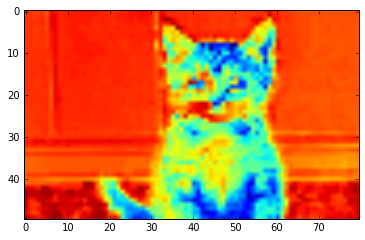

In [12]:
# Display the result of pooling the first ROI
plt.imshow(result_out[0, 0, 0, :, :].reshape(output_shape))

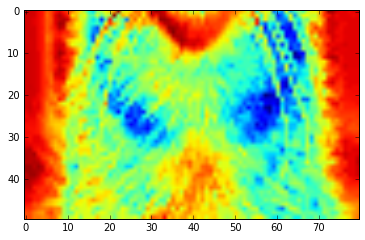

In [13]:
# Display the result of pooling the second ROI
plt.imshow(result_out[0, 0, 1, :, :].reshape(output_shape))

In [14]:
# Print a sample of argmax_out. Contains the locations that the max pooling
# value for each output pixel was found. For example, pixel (0, 0) in the first
# ROI pooling output was found at index 3 (indices in the flattened version of the
# input feature map).
argmax_out

array([[[[[     3,    408,    413, ...,    386,    393,    395],
          [  4031,   2423,   2428, ...,   2804,   3616,   2813],
          [  5243,   5647,   6458, ...,   6836,   6034,   6843],
          ..., 
          [115661, 115666, 114063, ..., 116050, 115247, 116058],
          [116064, 116069, 118093, ..., 118467, 117260, 118075],
          [119288, 120504, 120508, ..., 120884, 119275, 118879]],

         [[ 60600,  60602,  60604, ...,  60754,  60757,  60759],
          [ 61003,  61005,  61007, ...,  61157,  61159,  61161],
          [ 61406,  61408,  61410, ...,  61560,  61562,  61564],
          ..., 
          [ 79541,  79543,  79545, ...,  79696,  79698,  79700],
          [ 79945,  79946,  79948, ...,  80099,  80101,  80103],
          [ 80347,  80349,  80351, ...,  80502,  80504,  80506]]]]], dtype=int32)

In [15]:
# Shows the first 100 elements of the back-propagated gradient.
# The gradient computation connects all pixels from the input that were chosen
# during max pooling to the upstream gradient. Thus, all pixels that were not
# chosen will have a computed gradient of 0.
gradient_out.flatten()[:100]

array([   0.,    0.,    0.,  223.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,  225.,    0.,    0.,
          0.,    0.,  224.,    0.,    0.,    0.,    0.,  223.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,  225.,    0.,  225.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,  223.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,  224.,    0.,    0.,    0.,    0.,
          0.,  225.,    0.,    0.,    0.,  225.,    0.,    0.,    0.,    0.], dtype=float32)